In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 4 — Supervised Learning Basics
## Lesson 3: Logistic Regression: Binary Classification

**Course:** Introductory Course of Machine Learning (Chapters 1–14) + Advanced Topics (Chapters 15–37)  
**Notebook focus:** Logistic regression for **binary classification** on tabular data, with practical model evaluation, thresholding, regularization, and interpretation.

> This notebook follows the repository layout you described. All dataset paths are **relative** to this notebook location, e.g. `../../../Datasets/Classification/diabetes.csv`.

---

### Learning objectives

By the end of this lesson you will be able to:

1. Explain logistic regression in terms of **probabilities**, **odds**, and **log-odds**.
2. Build end-to-end binary classification pipelines using scikit-learn.
3. Evaluate classifiers using **confusion matrices**, **ROC-AUC**, **precision/recall**, and **log-loss**.
4. Choose decision **thresholds** based on costs and business objectives.
5. Understand the role of **regularization** (L2/L1) and tune hyperparameters responsibly.
6. Interpret fitted coefficients via **odds ratios** and understand practical limitations.
7. Avoid common pitfalls such as data leakage, mis-calibration, and improper preprocessing.

### Datasets used (selected for this lesson)

To avoid repeating the same dataset across lessons, this notebook demonstrates logistic regression on **two different classification datasets** from your repo:

- `diabetes.csv` (binary label: `Diabetic` vs `Non-Diabetic`)
- `drug200.csv` (converted to binary label: `DrugY` vs `Other`)

---

### Table of contents

1. Intuition: from scores to probabilities
2. Mathematical formulation (sigmoid, log-odds, likelihood)
3. Optimization and solvers (what scikit-learn actually does)
4. Practical workflow on `diabetes.csv` (pipeline + evaluation)
5. Metrics that matter (and when they matter)
6. Threshold tuning, decision costs, and utility
7. Calibration sanity checks (do probabilities mean what you think?)
8. Coefficient interpretation (odds ratios) and practical caveats
9. Regularization + hyperparameter tuning (CV)
10. Feature engineering for logistic regression (interactions & nonlinearity)
11. A second pipeline with mixed features: `drug200.csv`
12. Common pitfalls and debugging checklist
13. Exercises (with increasing difficulty)

---



## 1) Intuition: logistic regression as “probabilistic linear model”

Many supervised learning tasks boil down to answering:

> “Given features $x$, what is the probability that the label is 1?”

Logistic regression does exactly that with a **linear score** plus a **squashing function**.

### 1.1 Linear score (a.k.a. logit before the sigmoid)

We start with a linear predictor:

$$
z = w^\top x + b
$$

- $x \in \mathbb{R}^d$ is the feature vector.
- $w \in \mathbb{R}^d$ are coefficients (weights).
- $b$ is the intercept (bias term).

A pure linear model would map $z$ directly to the output, but for **classification** we need a number in $[0,1]$ that we can interpret as a probability.

### 1.2 Sigmoid link: score $\to$ probability

Logistic regression uses the sigmoid function:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Then the model’s predicted probability is:

$$
p(y=1 \mid x) = \sigma(w^\top x + b)
$$

This ensures valid probabilities:

- Large positive $z$ pushes $\sigma(z)$ close to 1.
- Large negative $z$ pushes $\sigma(z)$ close to 0.
- $z=0$ gives $\sigma(0)=0.5$ (the “coin flip” point).

### 1.3 Odds and log-odds (the most important interpretation)

Define **odds**:

$$
\text{odds} = \frac{p}{1-p}
$$

Take the log:

$$
\log\left(\frac{p}{1-p}\right) = w^\top x + b
$$

This is crucial:

- Logistic regression is **linear in the log-odds**.
- Each coefficient $w_j$ describes how a one-unit change in feature $x_j$ shifts log-odds (holding others constant).
- Exponentiating gives **odds ratios**:
  $$
  \text{OR}_j = e^{w_j}
  $$

If $w_j = 0.7$, then $e^{0.7} \approx 2.01$, meaning “a one-unit increase in $x_j$ multiplies odds by about 2” (when all else is fixed).

### 1.4 Decision boundary

If you predict class 1 when $p \ge 0.5$, you are predicting class 1 when:

$$
\sigma(z) \ge 0.5 \iff z \ge 0
$$

So the decision boundary is:

$$
w^\top x + b = 0
$$

That is a **hyperplane** in feature space, which is why logistic regression is a strong baseline for problems with approximately linear separation in the right feature representation.

---

## 2) Mathematical formulation (loss, likelihood, regularization)

### 2.1 Bernoulli likelihood

For binary labels $y \in \{0,1\}$, the conditional probability is:

$$
p(y \mid x) = p^y (1-p)^{1-y}
$$

where $p=\sigma(w^\top x + b)$. For a dataset $\{(x_i, y_i)\}_{i=1}^n$, the likelihood is:

$$
\mathcal{L}(w,b) = \prod_{i=1}^n p_i^{y_i}(1-p_i)^{1-y_i}
$$

We typically maximize the log-likelihood. Equivalently, minimize the negative log-likelihood (NLL):

$$
\text{NLL}(w,b) = -\sum_{i=1}^n \Big[y_i \log p_i + (1-y_i)\log(1-p_i)\Big]
$$

This is exactly **binary cross-entropy** (a.k.a. log-loss).

### 2.2 Regularization (capacity control)

In practice, we add a penalty to discourage overly large coefficients (which often improves generalization and numerical stability). The common choices are:

- **L2 (Ridge) penalty:**
  $$
  \lambda \lVert w \rVert_2^2
  $$
- **L1 (Lasso) penalty:**
  $$
  \lambda \lVert w \rVert_1
  $$

The optimization objective becomes:

$$
\min_{w,b}\ \text{NLL}(w,b) + \lambda \Omega(w)
$$

In scikit-learn, the hyperparameter is usually expressed as **$C$**, the inverse of regularization strength:

- Smaller $C$ $\Rightarrow$ stronger regularization.
- Larger $C$ $\Rightarrow$ weaker regularization.

### 2.3 Why scaling matters

Even though logistic regression is “simple”, it is sensitive to feature scaling because:

- Regularization penalizes coefficients; if features have wildly different magnitudes, the penalty interacts with scale.
- Many solvers converge faster and more reliably when features are standardized.

A safe default for numeric features is:

1. Impute missing values (if any)
2. Standardize (zero mean, unit variance)
3. Fit logistic regression

### 2.4 Calibration vs discrimination (a common confusion)

Logistic regression often produces reasonably calibrated probabilities, but not always. Two concepts:

- **Discrimination:** can the model rank positives above negatives? (ROC-AUC measures this)
- **Calibration:** do predicted probabilities match observed frequencies? (calibration curves / Brier score)

A model can have good ROC-AUC but poor calibration (and vice versa). In production systems, you often care about both.

---



## 3) Optimization and solvers (what scikit-learn actually does)

Logistic regression is often introduced as “simple,” but in practice the training process is an **optimization problem**. Understanding solvers helps you debug convergence warnings, choose regularization, and scale to larger datasets.

### 3.1 Convexity (why it matters)

For standard logistic regression with L2 regularization, the objective is **convex** in $(w,b)$. This means:

- There is a single global optimum (no “bad local minima”).
- Optimization is usually stable (if preprocessing is sane).
- Solver failures are often due to data issues (scale, separability, outliers) rather than nonconvexity.

### 3.2 Gradient and Hessian (conceptual)

If we write the log-loss objective (without regularization) for $y_i\in\{0,1\}$ as:

$$
J(w,b) = -\sum_{i=1}^n \left[y_i \log p_i + (1-y_i)\log(1-p_i)\right]
$$

with $p_i=\sigma(w^\top x_i+b)$, then the gradient has a simple “prediction minus truth” structure:

$$
\nabla_w J = \sum_{i=1}^n (p_i - y_i)\, x_i
$$

This reveals an important intuition: each sample pushes $w$ in proportion to its feature vector and the residual $(p_i-y_i)$.

The Hessian involves a term $p_i(1-p_i)$, which is largest when $p_i\approx 0.5$ and small when probabilities saturate near 0 or 1. This explains why saturated probabilities can slow down certain optimization dynamics.

### 3.3 Common solvers in scikit-learn

scikit-learn provides multiple solvers. The choice matters when you use L1/elastic-net, large sparse one-hot matrices, or want speed/stability.

- **`lbfgs`** (default for many cases)  
  Quasi-Newton method, strong general-purpose choice for L2 on small/medium dense data.

- **`liblinear`**  
  Coordinate-descent / linear SVM style solver; supports L1 and L2 but is usually slower for large datasets; binary classification works well.

- **`saga`**  
  Stochastic optimizer; supports L1, L2, and elastic-net; good for large datasets and sparse features (e.g., text or heavy one-hot).

- **`newton-cg`** / **`sag`**  
  Useful in some regimes; `sag` is a stochastic average gradient method and can be fast for large datasets with proper scaling.

### 3.4 Perfect (or near-perfect) separation

A classic logistic regression issue: if the classes are perfectly separable, the maximum likelihood estimate can drive coefficients toward infinity (the model tries to make probabilities 0/1 with extreme weights). Regularization usually fixes this, but you might see:

- Very large coefficient magnitudes
- Convergence warnings
- Overconfident probabilities (poor calibration)

### 3.5 Practical solver guidance

A pragmatic selection rule for tabular data:

- Mostly numeric, medium size: start with `lbfgs` + L2
- Need sparsity / feature selection: `saga` + L1 (or elastic-net)
- Heavy categorical one-hot with many columns: `saga` is often the best starting point
- If you see convergence warnings: scale features, increase `max_iter`, reduce `C` (stronger regularization), and check for outliers

---


In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    log_loss, precision_recall_curve, average_precision_score, brier_score_loss
)

# Calibration
from sklearn.calibration import calibration_curve

# Reproducibility
RANDOM_STATE = 42

In [3]:
def summarize_binary_metrics(y_true, y_proba, threshold=0.5):
    """Return a dict of common binary classification metrics at a given threshold."""
    y_pred = (y_proba >= threshold).astype(int)

    out = {
        "threshold": float(threshold),
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "log_loss": float(log_loss(y_true, y_proba)),
        "brier": float(brier_score_loss(y_true, y_proba)),
        "support_pos": int(np.sum(y_true == 1)),
        "support_neg": int(np.sum(y_true == 0)),
    }
    return out

def plot_confusion_matrix(cm, labels=("0", "1"), title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
    ax.set_xticklabels(labels); ax.set_yticklabels(labels)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC-AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

def plot_precision_recall(y_true, y_proba, title="Precision-Recall Curve"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

def plot_calibration_curve(y_true, y_proba, n_bins=10, title="Calibration Curve"):
    frac_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=n_bins, strategy="quantile")
    plt.figure(figsize=(6, 4))
    plt.plot(mean_pred, frac_pos, marker="o", label="model")
    plt.plot([0, 1], [0, 1], linestyle="--", label="perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()


## 4) Practical workflow on `diabetes.csv` (pipeline + evaluation)

Before building a model, it is good practice to establish a **baseline**. Baselines act as “reality checks”:

- If a sophisticated model is not better than a simple baseline, something is wrong.
- If a very simple model is suspiciously good, you may have leakage.

We will build two baselines:

1. **Majority class baseline** using `DummyClassifier(strategy="most_frequent")`  
2. **Logistic regression** pipeline with imputation + scaling

Then we will compare metrics.

### 4.1 Loading the dataset

We load data using the repository’s relative path.

---


In [4]:
path = "../../../Datasets/Classification/diabetes.csv"
df = pd.read_csv(path)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [5]:
df.shape, df.dtypes

((768, 9),
 Pregnancies                   int64
 Glucose                       int64
 BloodPressure                 int64
 SkinThickness                 int64
 Insulin                       int64
 BMI                         float64
 DiabetesPedigreeFunction    float64
 Age                           int64
 classification               object
 dtype: object)

In [6]:
# Basic missingness check (NaNs)
df.isna().mean().sort_values(ascending=False).head(10)

Pregnancies                 0.0
Glucose                     0.0
BloodPressure               0.0
SkinThickness               0.0
Insulin                     0.0
BMI                         0.0
DiabetesPedigreeFunction    0.0
Age                         0.0
classification              0.0
dtype: float64


### 4.2 Cleaning and target mapping

We will:

- Replace zeros with missing values for a few medically implausible columns  
- Create a binary target `y` where 1 means “Diabetic”  
- Keep the rest as features

This kind of domain-driven cleaning is common in tabular ML. The goal is not perfection; the goal is to make reasonable, documented decisions.

---


In [7]:
# Convert known "zero-as-missing" columns to NaN
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df_clean = df.copy()

for col in zero_as_missing:
    df_clean[col] = df_clean[col].replace(0, np.nan)

# Map target to binary 0/1
df_clean["y"] = (df_clean["classification"].str.strip().str.lower() == "diabetic").astype(int)

# Features and target
X = df_clean.drop(columns=["classification", "y"])
y = df_clean["y"]

y.value_counts(normalize=True).rename("class_fraction")

y
0    0.651042
1    0.348958
Name: class_fraction, dtype: float64


### 4.3 Train/test split (stratified)

For classification, stratification is often important so the class proportions are similar in train and test.

---


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape

((576, 8), (192, 8))

In [9]:
# Baseline: always predict the majority class
dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)

# For probability-based metrics, we still need "probabilities"
# DummyClassifier exposes predict_proba
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]

pd.Series(summarize_binary_metrics(y_test.values, y_dummy_proba, threshold=0.5)).rename("dummy_most_frequent")

threshold        0.500000
accuracy         0.651042
precision        0.000000
recall           0.000000
f1               0.000000
roc_auc          0.500000
log_loss        12.577733
brier            0.348958
support_pos     67.000000
support_neg    125.000000
Name: dummy_most_frequent, dtype: float64


### 4.4 Logistic regression pipeline (impute + scale + model)

A common mistake is to scale/impute on the full dataset before splitting. That causes **data leakage** because information from the test set influences preprocessing statistics (means, medians, etc.).

To avoid leakage, use a `Pipeline` so that preprocessing is **fit only on the training data** and then applied to the test set.

For numeric features we will:

- Impute missing values with the median
- Standardize features
- Fit a logistic regression classifier

We start with `penalty="l2"` and `solver="lbfgs"`.

---


In [10]:
numeric_features = X.columns.tolist()

numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

clf = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    penalty="l2",
    C=1.0,
    random_state=RANDOM_STATE
)

pipe = Pipeline(steps=[
    ("preprocess", numeric_preprocess),
    ("model", clf),
])

pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('model', LogisticRegression(max_iter=2000, random_state=42))])

In [11]:
pipe.fit(X_train, y_train)

# Predicted probabilities for class 1
y_proba = pipe.predict_proba(X_test)[:, 1]

pd.DataFrame({
    "dummy": pd.Series(summarize_binary_metrics(y_test.values, y_dummy_proba, threshold=0.5)),
    "logreg": pd.Series(summarize_binary_metrics(y_test.values, y_proba, threshold=0.5)),
})

,dummy,logreg
threshold,0.500000,0.500000
accuracy,0.651042,0.723958
precision,0.000000,0.629630
recall,0.000000,0.507463
f1,0.000000,0.561983
roc_auc,0.500000,0.823881
log_loss,12.577733,0.498623
brier,0.348958,0.169933
support_pos,67.000000,67.000000
support_neg,125.000000,125.000000


              precision    recall  f1-score   support

           0      0.761     0.840     0.798       125
           1      0.630     0.507     0.562        67

    accuracy                          0.724       192
   macro avg      0.695     0.674     0.680       192
weighted avg      0.715     0.724     0.716       192



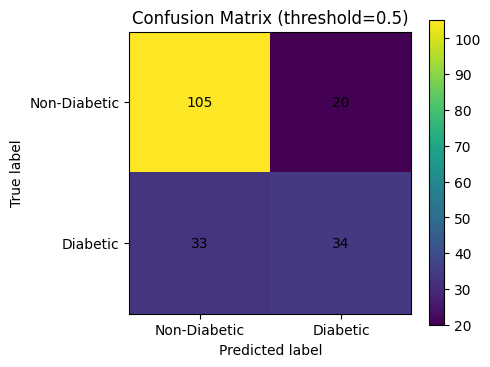

In [12]:
y_pred_05 = (y_proba >= 0.5).astype(int)

print(classification_report(y_test, y_pred_05, digits=3))

cm = confusion_matrix(y_test, y_pred_05)
plot_confusion_matrix(cm, labels=("Non-Diabetic", "Diabetic"), title="Confusion Matrix (threshold=0.5)")

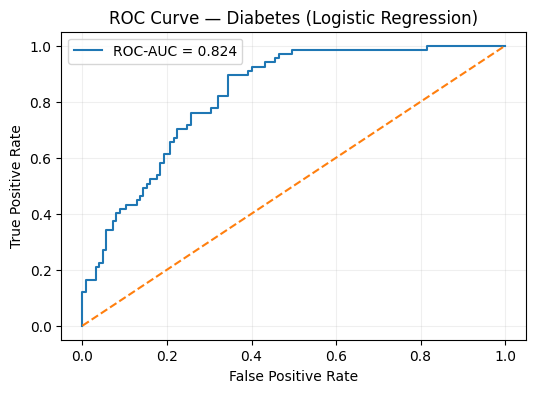

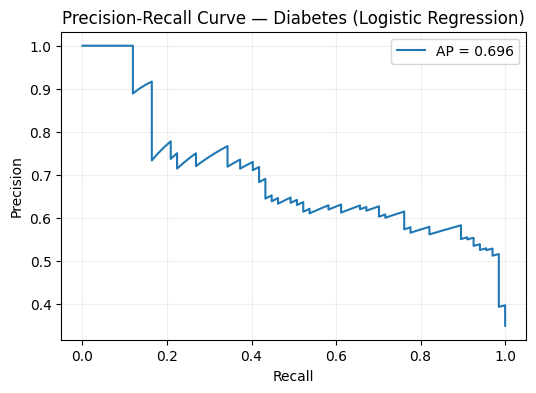

In [13]:
plot_roc(y_test.values, y_proba, title="ROC Curve — Diabetes (Logistic Regression)")
plot_precision_recall(y_test.values, y_proba, title="Precision-Recall Curve — Diabetes (Logistic Regression)")


## 5) Metrics that matter (and when they matter)

Binary classification metrics are not interchangeable. Choosing the wrong metric can produce a model that looks “good” on paper but fails in the real task.

### 5.1 Confusion matrix terminology

For a binary classifier with predicted labels $\hat{y}$ and true labels $y$:

- **TP**: true positives (predict 1 when $y=1$)
- **TN**: true negatives (predict 0 when $y=0$)
- **FP**: false positives (predict 1 when $y=0$)
- **FN**: false negatives (predict 0 when $y=1$)

### 5.2 Common metrics

- **Accuracy**: $(TP + TN)/(TP+TN+FP+FN)$  
  Useful when classes are balanced and error costs are symmetric.

- **Precision**: $TP/(TP+FP)$  
  Useful when false positives are costly (e.g., flagging legitimate transactions as fraud).

- **Recall** (Sensitivity): $TP/(TP+FN)$  
  Useful when false negatives are costly (e.g., missing a disease case).

- **F1-score**: harmonic mean of precision and recall  
  Useful when you want a single number that balances both.

- **ROC-AUC**: probability the model ranks a random positive higher than a random negative  
  Useful for ranking quality; relatively insensitive to threshold choice.

- **Log-loss** (cross-entropy): penalizes wrong confident probabilities  
  Useful when probability calibration matters.

- **Brier score**: mean squared error of probabilities  
  $$
  \text{Brier} = \frac{1}{n}\sum_{i=1}^n (p_i - y_i)^2
  $$
  Useful as a simple combined measure of probability accuracy and calibration.

### 5.3 ROC curve vs PR curve

When positives are rare, PR curves can be more informative than ROC curves because they focus on precision and recall directly.

### 5.4 Metric selection cheat-sheet (practical)

- If you have **limited capacity** to action positives (e.g., manual review): look at **precision** at the chosen threshold and PR curves.
- If missing positives is very costly: focus on **recall** and consider costs/utility.
- If you need a single summary number for ranking: ROC-AUC (and also AP for imbalanced problems).
- If you consume probabilities downstream (risk scoring): check **log-loss**, **Brier**, and calibration curves.

---



## 6) Threshold tuning, decision costs, and utility

The default threshold $0.5$ is arbitrary. In real deployments you often pick a threshold based on:

- Business costs (FP vs FN)
- Capacity constraints (e.g., “we can only review 500 cases/day”)
- Service-level objectives (“recall must be at least 90%”)
- Risk tolerance and compliance constraints

### 6.1 Cost-based thresholding

Suppose:

- False negative cost: $C_{FN}$
- False positive cost: $C_{FP}$

A simple expected cost at threshold $t$ can be approximated via the confusion matrix:

$$
\text{Cost}(t) = C_{FN}\cdot FN(t) + C_{FP}\cdot FP(t)
$$

Then we pick:

$$
t^\* = \arg\min_t \text{Cost}(t)
$$

### 6.2 Utility framing (optional but powerful)

Sometimes it is easier to express gains rather than costs. Let:

- Benefit of a true positive be $B_{TP}$
- Benefit of a true negative be $B_{TN}$
- Cost of a false positive be $C_{FP}$
- Cost of a false negative be $C_{FN}$

Then expected utility at threshold $t$:

$$
U(t) = B_{TP}\cdot TP(t) + B_{TN}\cdot TN(t) - C_{FP}\cdot FP(t) - C_{FN}\cdot FN(t)
$$

Pick the threshold that maximizes $U(t)$. This is common in risk systems (fraud, credit, medical triage).

### 6.3 Operating point selection

A practical pattern:

1. Compute metrics over a grid of thresholds
2. Visualize tradeoffs (precision/recall vs threshold)
3. Choose a threshold that meets constraints (e.g., recall $\ge 0.85$)
4. Validate on a held-out set (and later in production)

---


In [14]:
thresholds = np.linspace(0.05, 0.95, 19)

rows = []
for t in thresholds:
    rows.append(summarize_binary_metrics(y_test.values, y_proba, threshold=float(t)))

df_thr = pd.DataFrame(rows)
df_thr.head()

,threshold,accuracy,precision,recall,f1,roc_auc,log_loss,brier,support_pos,support_neg
0,0.05,0.463542,0.392857,0.985075,0.561702,0.823881,0.498623,0.169933,67,125
1,0.10,0.583333,0.455172,0.985075,0.622642,0.823881,0.498623,0.169933,67,125
2,0.15,0.692708,0.533898,0.940299,0.681081,0.823881,0.498623,0.169933,67,125
3,0.20,0.718750,0.560748,0.895522,0.689655,0.823881,0.498623,0.169933,67,125
4,0.25,0.718750,0.565657,0.835821,0.674699,0.823881,0.498623,0.169933,67,125


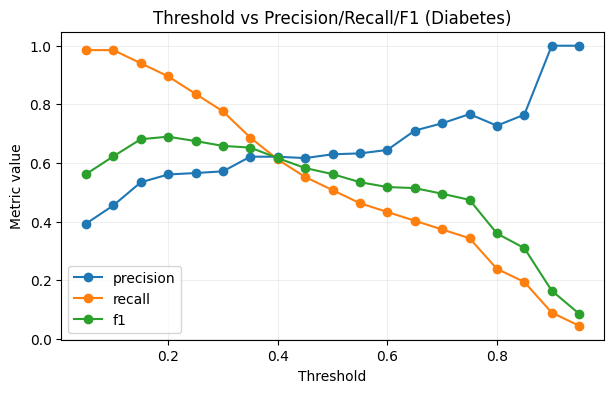

In [15]:
plt.figure(figsize=(7, 4))
plt.plot(df_thr["threshold"], df_thr["precision"], marker="o", label="precision")
plt.plot(df_thr["threshold"], df_thr["recall"], marker="o", label="recall")
plt.plot(df_thr["threshold"], df_thr["f1"], marker="o", label="f1")
plt.xlabel("Threshold")
plt.ylabel("Metric value")
plt.title("Threshold vs Precision/Recall/F1 (Diabetes)")
plt.grid(True, alpha=0.2)
plt.legend()
plt.show()

In [16]:
# Example: choose threshold minimizing a simple expected cost
# You can adjust these numbers based on your application
C_FN = 5.0   # cost of missing a positive
C_FP = 1.0   # cost of a false alarm

def expected_cost(y_true, y_proba, t, c_fn=C_FN, c_fp=C_FP):
    y_pred = (y_proba >= t).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return c_fn * fn + c_fp * fp

df_thr["expected_cost"] = [expected_cost(y_test.values, y_proba, t) for t in df_thr["threshold"]]
best_row = df_thr.loc[df_thr["expected_cost"].idxmin()]
best_row

threshold          0.150000
accuracy           0.692708
precision          0.533898
recall             0.940299
f1                 0.681081
roc_auc            0.823881
log_loss           0.498623
brier              0.169933
support_pos       67.000000
support_neg      125.000000
expected_cost     75.000000
Name: 2, dtype: float64

Chosen threshold = 0.15
              precision    recall  f1-score   support

           0      0.946     0.560     0.704       125
           1      0.534     0.940     0.681        67

    accuracy                          0.693       192
   macro avg      0.740     0.750     0.692       192
weighted avg      0.802     0.693     0.696       192



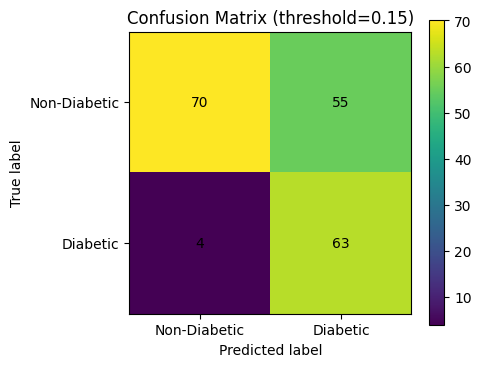

In [17]:
best_t = float(best_row["threshold"])
y_pred_best = (y_proba >= best_t).astype(int)

print(f"Chosen threshold = {best_t:.2f}")
print(classification_report(y_test, y_pred_best, digits=3))

cm_best = confusion_matrix(y_test, y_pred_best)
plot_confusion_matrix(cm_best, labels=("Non-Diabetic", "Diabetic"), title=f"Confusion Matrix (threshold={best_t:.2f})")


## 7) Calibration sanity checks (do probabilities mean what you think?)

If you use predicted probabilities for ranking, triage, or decisioning, you should ask:

> “When the model predicts 0.8, does the event happen about 80% of the time?”

This is **calibration**. Even if logistic regression is often reasonably calibrated, calibration can drift due to:

- Regularization
- Dataset shift (train vs production population differs)
- Feature engineering that changes effective model capacity
- Label noise and imperfect ground truth

### 7.1 Calibration curve

We can bin predictions and compare average predicted probability to observed frequency.

### 7.2 Brier score

Brier score is a simple probability accuracy measure:

$$
\text{Brier} = \frac{1}{n}\sum_{i=1}^n (p_i - y_i)^2
$$

Lower is better. Brier is sensitive to both discrimination and calibration.

---


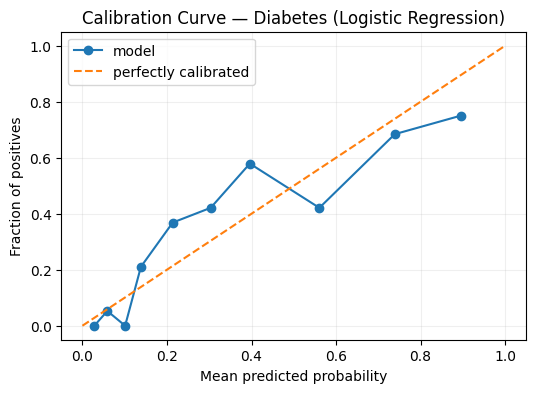

Brier score: 0.16993300596881036


In [18]:
plot_calibration_curve(y_test.values, y_proba, n_bins=10, title="Calibration Curve — Diabetes (Logistic Regression)")
print("Brier score:", brier_score_loss(y_test.values, y_proba))


## 8) Coefficient interpretation (odds ratios) and limitations

### 8.1 From coefficients to odds ratios

If the model uses features $x_j$ and coefficient $w_j$, then:

- A one-unit increase in $x_j$ changes the log-odds by $w_j$
- The odds ratio is $e^{w_j}$

For standardized features (mean 0, std 1), a “one-unit increase” means “one standard deviation increase”, which is often more meaningful.

### 8.2 Practical interpretation example

If a standardized feature has $w_j=0.3$, then $e^{0.3}\approx 1.35$. That means one standard deviation increase multiplies the odds of the positive class by about 1.35 (holding others fixed).

If $w_j=-0.7$, then $e^{-0.7}\approx 0.50$. That means one standard deviation increase halves the odds.

### 8.3 Caution: correlation and confounding

A coefficient being positive does **not** automatically imply a causal relationship. Logistic regression is predictive; coefficients can reflect:

- True associations
- Proxy effects (features correlated with the real driver)
- Confounding variables
- Leakage (if the feature contains post-outcome information)

### 8.4 Multicollinearity makes coefficients unstable

When features are highly correlated, many different coefficient vectors yield similar predictions. That can make individual coefficients noisy or counterintuitive. Regularization helps but does not “solve causality.”

---


In [19]:
# Extract coefficients in feature space (after preprocessing)
# Because we used a pipeline with scaling, coefficients correspond to scaled features.
model = pipe.named_steps["model"]
coefs = pd.Series(model.coef_.ravel(), index=numeric_features).sort_values(key=np.abs, ascending=False)

odds_ratios = np.exp(coefs)

pd.DataFrame({
    "coef": coefs,
    "odds_ratio": odds_ratios
}).head(12)

,coef,odds_ratio
Glucose,1.161356,3.194262
BMI,0.723911,2.062485
Pregnancies,0.440424,1.553366
DiabetesPedigreeFunction,0.212235,1.236439
Age,0.126012,1.134296
SkinThickness,-0.058248,0.943416
BloodPressure,-0.057382,0.944233
Insulin,-0.030690,0.969776



## 9) Regularization + hyperparameter tuning (cross-validation)

In scikit-learn logistic regression, `C` controls regularization strength:

- Smaller `C` $\Rightarrow$ stronger regularization (simpler model, potentially less variance)
- Larger `C` $\Rightarrow$ weaker regularization (more flexible, potentially overfitting)

### 9.1 Why tune with cross-validation?

If you tune hyperparameters on the test set, you leak information and get overly optimistic estimates. Use cross-validation on training data, then evaluate once on the test set.

### 9.2 What should you optimize?

- If you care about ranking quality: optimize ROC-AUC
- If positives are rare: optimize average precision (AP)
- If decisions use probabilities: consider log-loss as an optimization objective
- If you have explicit costs: optimize expected utility/cost at the target operating point

In this lesson we tune `C` using stratified 5-fold CV and ROC-AUC.

---


In [20]:
param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

grid.best_params_, grid.best_score_

({'model__C': 0.1}, np.float64(0.8345398373983739))

In [21]:
# View CV results
results = pd.DataFrame(grid.cv_results_).sort_values("rank_test_score")
results[["params", "mean_test_score", "std_test_score", "rank_test_score"]]

,params,mean_test_score,std_test_score,rank_test_score
1,{'model__C': 0.1},0.834540,0.021105,1
0,{'model__C': 0.01},0.832377,0.022279,2
2,{'model__C': 1.0},0.830525,0.022805,3
3,{'model__C': 10.0},0.830189,0.022213,4
4,{'model__C': 100.0},0.830120,0.022043,5


In [22]:
best_pipe = grid.best_estimator_
y_proba_best = best_pipe.predict_proba(X_test)[:, 1]

pd.Series(summarize_binary_metrics(y_test.values, y_proba_best, threshold=0.5))

threshold        0.500000
accuracy         0.729167
precision        0.636364
recall           0.522388
f1               0.573770
roc_auc          0.822806
log_loss         0.495075
brier            0.167964
support_pos     67.000000
support_neg    125.000000
dtype: float64


## 10) Feature engineering for logistic regression (interactions & nonlinearity)

Logistic regression is linear in the features it sees. If the relationship is nonlinear, you have two options:

1. Use a nonlinear model (trees, kernels, neural nets), or
2. Engineer features so that the boundary becomes approximately linear

A classic approach is adding **interaction** or **polynomial** terms. For two features $x_1$ and $x_2$, adding $x_1x_2$ allows the model to capture multiplicative interactions. Adding $x_1^2$ and $x_2^2$ allows curved boundaries.

Important caveats:

- Polynomial features can explode dimensionality quickly.
- Regularization becomes essential.
- Interpretation becomes more complex.

Here we demonstrate a simple polynomial feature pipeline (degree 2) on a subset of numeric features as an example.

---


In [23]:
# Example: polynomial features on a subset to avoid too many terms
poly_features = ["Glucose", "BMI", "Age"]  # you can adjust

X_poly = df_clean[poly_features].copy()
y_poly = df_clean["y"].copy()

X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(
    X_poly, y_poly, test_size=0.25, random_state=RANDOM_STATE, stratify=y_poly
)

poly_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("model", LogisticRegression(max_iter=5000, solver="lbfgs", C=1.0, random_state=RANDOM_STATE)),
])

poly_pipe.fit(X_poly_train, y_poly_train)
y_poly_proba = poly_pipe.predict_proba(X_poly_test)[:, 1]

pd.Series(summarize_binary_metrics(y_poly_test.values, y_poly_proba, threshold=0.5)).rename("poly_degree2")

threshold        0.500000
accuracy         0.760417
precision        0.677966
recall           0.597015
f1               0.634921
roc_auc          0.828537
log_loss         0.482003
brier            0.163785
support_pos     67.000000
support_neg    125.000000
Name: poly_degree2, dtype: float64


### 10.1 Visualizing a decision boundary in 2D (educational)

For high-dimensional problems, decision boundaries are hard to visualize. But with two features, we can plot how logistic regression separates the plane.

Below we train a model using only two features (e.g., `Glucose` and `BMI`) and visualize the $p(y=1|x)$ surface as a contour plot. This is mainly for intuition.

---


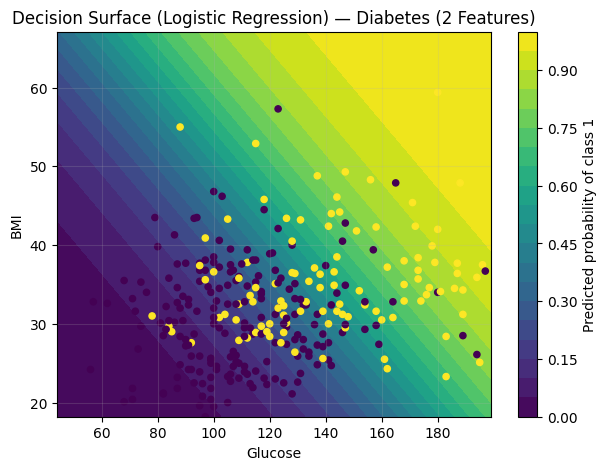

In [24]:
two_features = ["Glucose", "BMI"]

X2d = df_clean[two_features].copy()
y2d = df_clean["y"].copy()

X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(
    X2d, y2d, test_size=0.25, random_state=RANDOM_STATE, stratify=y2d
)

pipe2d = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=5000, solver="lbfgs", C=1.0, random_state=RANDOM_STATE)),
])

pipe2d.fit(X2d_train, y2d_train)

# Create a grid
x_min, x_max = X2d[two_features[0]].min(), X2d[two_features[0]].max()
y_min, y_max = X2d[two_features[1]].min(), X2d[two_features[1]].max()

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

grid = pd.DataFrame({two_features[0]: xx.ravel(), two_features[1]: yy.ravel()})
zz = pipe2d.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(7, 5))
cs = plt.contourf(xx, yy, zz, levels=20)
plt.colorbar(cs, label="Predicted probability of class 1")

# Scatter points (a sample for clarity)
sample = df_clean.dropna(subset=two_features).sample(n=min(300, len(df_clean.dropna(subset=two_features))), random_state=RANDOM_STATE)
plt.scatter(sample[two_features[0]], sample[two_features[1]], c=sample["y"], s=20)

plt.xlabel(two_features[0])
plt.ylabel(two_features[1])
plt.title("Decision Surface (Logistic Regression) — Diabetes (2 Features)")
plt.grid(True, alpha=0.2)
plt.show()


## 11) From-scratch logistic regression (optional, but highly recommended)

Using scikit-learn is practical, but implementing core pieces once builds intuition and makes you better at debugging.

We will implement:

1. A numerically stable sigmoid  
2. Log-loss  
3. Gradient descent for logistic regression (with L2 regularization)  

Then we compare the learned coefficients (roughly) with scikit-learn on the same standardized data.

Notes:

- This is not meant to beat scikit-learn; it is a learning exercise.
- We keep it simple and use batch gradient descent.
- We use standardized features to make step sizes reasonable.

---


In [25]:
def sigmoid(z):
    # Numerically stable sigmoid
    z = np.asarray(z)
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    neg = ~pos
    out[pos] = 1 / (1 + np.exp(-z[pos]))
    ez = np.exp(z[neg])
    out[neg] = ez / (1 + ez)
    return out

def log_loss_manual(y_true, y_proba, eps=1e-15):
    y_proba = np.clip(y_proba, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_proba) + (1 - y_true) * np.log(1 - y_proba))

def fit_logreg_gd(X, y, lr=0.1, n_iter=2000, lam=0.0):
    """Binary logistic regression with L2 regularization using batch gradient descent.
    X: (n, d) numpy array
    y: (n,) in {0,1}
    lam: L2 strength (lambda)
    Returns: w (d,), b (scalar), history (list of loss values)
    """
    n, d = X.shape
    w = np.zeros(d)
    b = 0.0
    history = []

    for it in range(n_iter):
        z = X @ w + b
        p = sigmoid(z)

        # Gradient
        grad_w = (X.T @ (p - y)) / n + 2 * lam * w
        grad_b = np.mean(p - y)

        # Update
        w -= lr * grad_w
        b -= lr * grad_b

        if it % 100 == 0 or it == n_iter - 1:
            loss = log_loss_manual(y, p) + lam * np.sum(w**2)
            history.append(loss)

    return w, b, history

# Prepare a standardized matrix for from-scratch training
X_num = df_clean.drop(columns=["classification", "y"]).copy()

# median impute, then standardize
X_num_imputed = X_num.fillna(X_num.median(numeric_only=True))
X_mat = X_num_imputed.to_numpy(dtype=float)
y_vec = df_clean["y"].to_numpy(dtype=float)

# standardize manually
mu = X_mat.mean(axis=0)
sd = X_mat.std(axis=0) + 1e-12
X_std = (X_mat - mu) / sd

# Train with GD
w_gd, b_gd, hist = fit_logreg_gd(X_std, y_vec, lr=0.2, n_iter=3000, lam=0.01)

# Compare loss
p_gd = sigmoid(X_std @ w_gd + b_gd)
print("Manual log-loss:", log_loss_manual(y_vec, p_gd))
print("sklearn log-loss:", log_loss(y_vec, pipe.fit(X_num, y_vec).predict_proba(X_num)[:, 1]))

# Show top coefficients by magnitude
coef_gd = pd.Series(w_gd, index=X_num.columns).sort_values(key=np.abs, ascending=False)
coef_gd.head(10)

Manual log-loss: 0.4669205610600204
sklearn log-loss: 0.4641107172627246


Glucose                     0.950633
BMI                         0.519957
Pregnancies                 0.345296
DiabetesPedigreeFunction    0.249623
Age                         0.162799
SkinThickness               0.073953
BloodPressure              -0.048491
Insulin                    -0.023759
dtype: float64

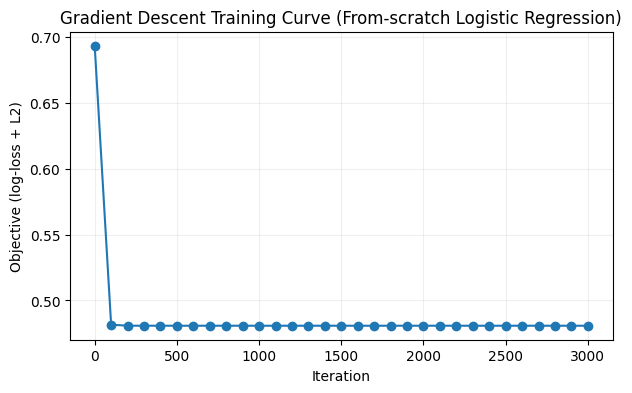

In [26]:
plt.figure(figsize=(7, 4))
plt.plot(np.arange(len(hist)) * 100, hist, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Objective (log-loss + L2)")
plt.title("Gradient Descent Training Curve (From-scratch Logistic Regression)")
plt.grid(True, alpha=0.2)
plt.show()


## 12) Second example: `drug200.csv` with mixed feature types

This dataset includes categorical features (`Sex`, `BP`, `Cholesterol`) and numeric features (`Age`, `Na_to_K`).

To demonstrate production-style preprocessing:

- Numeric columns: median imputation + standard scaling
- Categorical columns: most-frequent imputation + one-hot encoding
- Logistic regression on the transformed feature space

### 12.1 Converting to a binary target

Original target `Drug` has multiple classes. For **binary** logistic regression we will define:

- Positive class: `DrugY`
- Negative class: all other drugs (`drugA`, `drugB`, `drugC`, `drugX`, ...)

This is a common pattern when you have a “priority class” vs “rest.”

---


In [27]:
path2 = "../../../Datasets/Classification/drug200.csv"
drug = pd.read_csv(path2)
drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [28]:
# Binary target: DrugY vs Other
drug = drug.copy()
drug["y"] = (drug["Drug"].str.strip().str.lower() == "drugy").astype(int)

X2 = drug.drop(columns=["Drug", "y"])
y2 = drug["y"]

X2.dtypes, y2.value_counts(normalize=True).rename("class_fraction")

(Age              int64
 Sex             object
 BP              object
 Cholesterol     object
 Na_to_K        float64
 dtype: object,
 y
 0    0.545
 1    0.455
 Name: class_fraction, dtype: float64)

In [29]:
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=RANDOM_STATE, stratify=y2
)
X2_train.shape, X2_test.shape

((150, 5), (50, 5))

In [30]:
# Identify columns by type
num_cols = X2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X2.columns if c not in num_cols]

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ]
)

clf2 = LogisticRegression(
    max_iter=8000,
    solver="lbfgs",
    penalty="l2",
    C=1.0,
    random_state=RANDOM_STATE
)

pipe2 = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", clf2),
])

pipe2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Na_to_K']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Sex', 'BP',
                                                   'Cholesterol'])])),
                ('model', LogisticRegression(max_iter=8000, random_state=42))])

In [31]:
pipe2.fit(X2_train, y2_train)
y2_proba = pipe2.predict_proba(X2_test)[:, 1]

pd.Series(summarize_binary_metrics(y2_test.values, y2_proba, threshold=0.5))

threshold       0.500000
accuracy        0.920000
precision       1.000000
recall          0.826087
f1              0.904762
roc_auc         0.995169
log_loss        0.164959
brier           0.047915
support_pos    23.000000
support_neg    27.000000
dtype: float64

              precision    recall  f1-score   support

           0      0.871     1.000     0.931        27
           1      1.000     0.826     0.905        23

    accuracy                          0.920        50
   macro avg      0.935     0.913     0.918        50
weighted avg      0.930     0.920     0.919        50



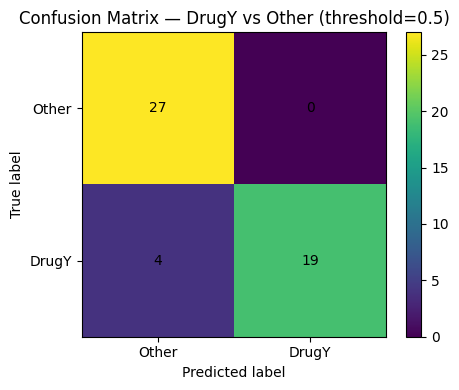

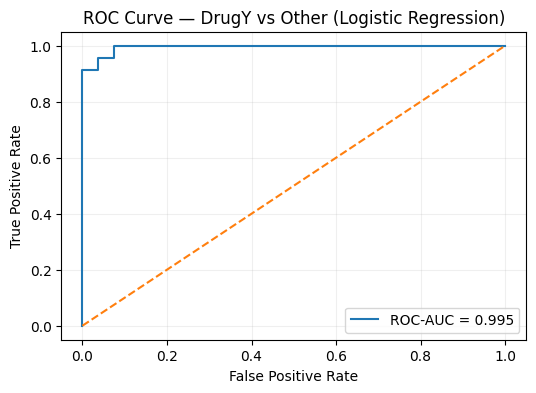

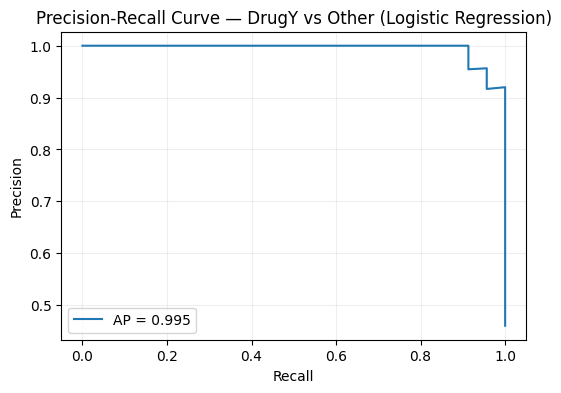

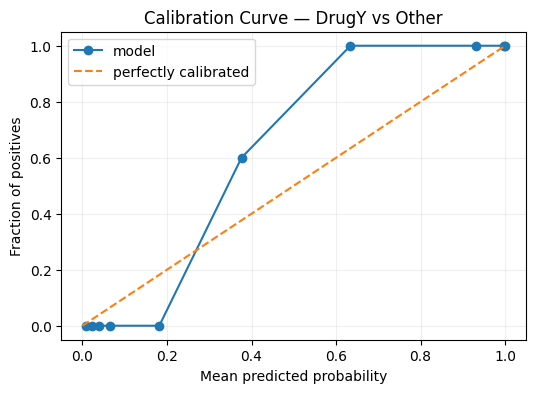

In [32]:
y2_pred = (y2_proba >= 0.5).astype(int)

print(classification_report(y2_test, y2_pred, digits=3))

cm2 = confusion_matrix(y2_test, y2_pred)
plot_confusion_matrix(cm2, labels=("Other", "DrugY"), title="Confusion Matrix — DrugY vs Other (threshold=0.5)")

plot_roc(y2_test.values, y2_proba, title="ROC Curve — DrugY vs Other (Logistic Regression)")
plot_precision_recall(y2_test.values, y2_proba, title="Precision-Recall Curve — DrugY vs Other (Logistic Regression)")
plot_calibration_curve(y2_test.values, y2_proba, n_bins=10, title="Calibration Curve — DrugY vs Other")


## 13) Imbalance handling (quick patterns)

If the positive class is rare, two simple patterns are worth knowing:

1. **Class weights:** reweight the loss to pay more attention to rare positives  
2. **Threshold tuning:** pick a lower threshold to increase recall  

Class weights are available directly in scikit-learn via `class_weight="balanced"`. This rescales loss contributions inversely proportional to class frequency.

Below we show a quick comparison using class weights on the `drug200.csv` binary task.

---


In [33]:
pipe2_balanced = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        max_iter=8000,
        solver="lbfgs",
        penalty="l2",
        C=1.0,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )),
])

pipe2_balanced.fit(X2_train, y2_train)
y2_proba_bal = pipe2_balanced.predict_proba(X2_test)[:, 1]

pd.DataFrame({
    "unweighted": pd.Series(summarize_binary_metrics(y2_test.values, y2_proba, threshold=0.5)),
    "class_weight_balanced": pd.Series(summarize_binary_metrics(y2_test.values, y2_proba_bal, threshold=0.5)),
})

,unweighted,class_weight_balanced
threshold,0.500000,0.500000
accuracy,0.920000,0.940000
precision,1.000000,1.000000
recall,0.826087,0.869565
f1,0.904762,0.930233
roc_auc,0.995169,0.995169
log_loss,0.164959,0.161113
brier,0.047915,0.045523
support_pos,23.000000,23.000000
support_neg,27.000000,27.000000



## 14) Common pitfalls and debugging checklist

Logistic regression is simple, which makes it a great tool for diagnosing pipeline issues. If you see weird results, check the following before blaming the model.

### 14.1 Leakage and split hygiene

- Did you fit preprocessing (imputer/scaler/encoder) on the full dataset?  
  Use a `Pipeline` to avoid leakage.
- Did you accidentally include the target (or a proxy) in features?
- Are there duplicates across train and test sets?
- Are there grouped entities (e.g., multiple rows per person)? If yes, use a group split.

### 14.2 Target encoding mistakes

- Are labels mapped correctly to 0/1?
- Are there unseen categories in test? (use `handle_unknown="ignore"`)

### 14.3 Class imbalance

- Accuracy can be misleading.
- Use PR curves, recall/precision, and consider `class_weight="balanced"`.
- Always tie imbalance choices to the operating objective (precision target, recall target, capacity constraints).

### 14.4 Solver and convergence issues

If you see convergence warnings:

- Increase `max_iter`
- Standardize numeric features
- Reduce `C` (stronger regularization) if coefficients get huge
- Consider a different solver (e.g., `liblinear` for L1 on small data; `saga` for L1/elastic-net on sparse data)

### 14.5 Probability calibration

If probabilities are used downstream, calibration drift is real. Always validate calibration on a representative validation set and re-check after deployment (Chapter 34: Monitoring).

---



## 15) Exercises

Work through these in order. Each one adds a practical capability you will use repeatedly throughout the course.

### Exercise 1 — Baseline without scaling (diagnose impact)
1. Remove the `StandardScaler()` step from the diabetes pipeline.
2. Fit and compare ROC-AUC and log-loss with the scaled pipeline.
3. Explain why the change affects (or does not affect) performance.

### Exercise 2 — Add L1 regularization (feature sparsity)
1. Change logistic regression to `penalty="l1"` and solver to `liblinear` or `saga`.
2. Tune `C` over a grid.
3. Count how many coefficients become exactly zero and discuss interpretability tradeoffs.

### Exercise 3 — Business threshold
Using `diabetes.csv`:
1. Define costs $C_{FN}=10$ and $C_{FP}=1$.
2. Choose a threshold minimizing expected cost.
3. Compare confusion matrices at $t=0.5$ and at the cost-minimizing threshold.

### Exercise 4 — Calibration sanity check
1. Produce a calibration curve for diabetes and compute the Brier score.
2. Explain whether you would trust raw probabilities for decisioning (and why).

### Exercise 5 — Compare solvers and convergence
1. Try `solver="liblinear"` and `solver="saga"` on the diabetes pipeline.
2. Compare training time, convergence behavior, and metrics.
3. For `saga`, try L1 regularization and observe coefficient sparsity.

### Exercise 6 — From-scratch: validate gradients (advanced)
1. For the from-scratch implementation, compute the gradient numerically (finite differences) on a tiny subset.
2. Compare numerical gradients with analytic gradients.
3. Explain why gradient checking is valuable for custom implementations.

### Exercise 7 — Mini case study
Pick a metric and operating constraint, for example:
- “Recall must be at least 0.85”
- “Precision must be at least 0.70”
- “Expected cost must be minimized under $C_{FN}=8, C_{FP}=1$”

Then:
1. Choose a threshold that satisfies the constraint.
2. Report confusion matrix and metrics at that threshold.
3. Write 5–10 lines explaining your reasoning.

---

## 16) Key takeaways

- Logistic regression models **log-odds** linearly: $\log\frac{p}{1-p}=w^\top x + b$.
- Evaluation depends on the application; metrics encode priorities.
- Thresholds should be chosen intentionally; $0.5$ is rarely optimal.
- Pipelines prevent leakage and make experimentation reproducible.
- Regularization is not optional; it is a core part of modern logistic regression practice.
- Calibration is the difference between “good ranking” and “trustworthy probabilities.”
